<a href="https://colab.research.google.com/github/mosovam/nn-medical-view/blob/main/Brain_Eye_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images

Kaggle source => https://www.kaggle.com/tinashri/brain-tumor-segmentation-datasets 

Files Path => /content/drive/MyDrive/OSU_IT/BC_MMO/data

Sharable folder link => https://drive.google.com/drive/folders/1WScjW-EqpLRfeL_gORreZ6s-Q4dnI5NZ?usp=sharing 

In [ ]:
# library and dependencies imports
import torch
from torchvision import transforms, datasets, utils, models
from PIL import Image, ImageOps
from glob import glob
import random
import numpy as np

In [ ]:
# global constants 

FOLDER_PATH = '/content/drive/MyDrive/OSU_IT/BC_MMO'
IMAGES_PATH = FOLDER_PATH + '/data/images'
MASKS_PATH = FOLDER_PATH + '/eye_data/masks'

CLASSES = ['eye', 'unlabelled']

### Google Drive connection

In [ ]:
# import the files from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load images from drive

In [ ]:
# glob all images and masks paths, sort them (without knowing their names)
import pathlib

im_suffix = '/*.png'
imgs_path = IMAGES_PATH + '/'
masks_path = MASKS_PATH + im_suffix

masks_path_list = glob(masks_path)
masks_path_list.sort()

images_path_list = []


for mask in masks_path_list:
  path = pathlib.PurePath(mask)
  image_path = imgs_path + path.name
  images_path_list.append(image_path)

  
images_path_list.sort()

### Show images

In [ ]:
# get random image number

def get_random_image_number(): 
  img_l_size = len(images_path_list)
  return random.randint(0, (img_l_size - 1))

In [ ]:
# get some random image and its masks

def get_random_image():
  img_l_size = len(images_path_list)
  random_image_number = get_random_image_number()

  img = Image.open(images_path_list[random_image_number])
  mask = Image.open(masks_path_list[random_image_number])

  print('Number of images and masks in directory:', img_l_size)
  print('Random image and mask with number:', random_image_number)

  return img, mask

In [ ]:
# show mask in original image function

def get_image_with_mask(o_img, m_img):
  mask_img_copy = m_img.copy()
  img_copy = o_img.copy()

  mask_img_copy = mask_img_copy.convert("RGBA")

  datas = mask_img_copy.getdata()

  newData = []

  # reset the black color in image to transparent
  for item in datas:
    # black RGB = (0, 0, 0)
    if item[0] == 0 and item[1] == 0 and item[2] == 0:
      newData.append((255, 255, 255, 0))
    else:
      newData.append(item)

  mask_img_copy.putdata(newData)

  # set the image opacity
  # mask_img_copy.putalpha(50)

  x, y = mask_img_copy.size

  img_copy.paste(mask_img_copy, (0, 0, x, y), mask_img_copy)

  return img_copy

Number of images and masks in directory: 3064
Random image and mask with number: 2620


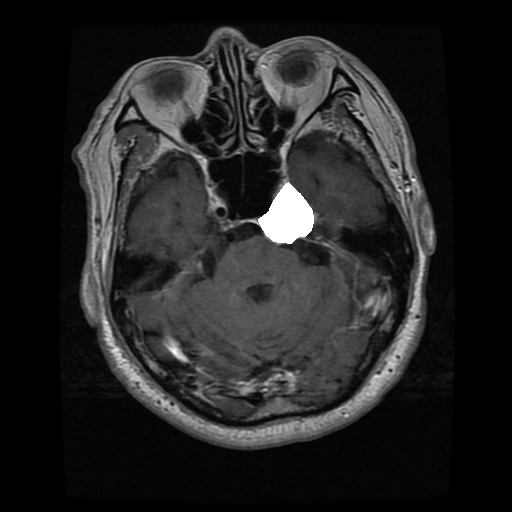

In [ ]:
i, m = get_random_image()
img_plus_mask = get_image_with_mask(i, m)

img_plus_mask

# Segmentation

https://segmentation-modelspytorch.readthedocs.io/en/latest/#quick-start

https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [ ]:
%pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 16.6 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bef8cbb9deb92e86af4e9e6f66e3d35e6dfee79ec99513d3ecc020f4962c0379
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0bce84e23f753f12239ccfd44d69d5f5da49677bed070dfa327c5a2909dd51b9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
# cannot import name '_registerMatType' from 'cv2.cv2' (/usr/local/lib/python3.7/dist-packages/cv2/cv2.cpython-37m-x86_64-linux-gnu.so)
# https://github.com/opencv/opencv-python/issues/591

!pip install "opencv-python-headless<4.3"


     |████████████████████████████████| 21.6 MB 1.3 MB/s 


In [ ]:
# module 'albumentations' has no attribute 'Lambda'

# NOT HELPING
## https://github.com/albumentations-team/albumentations/issues/414

# But 'Lambda' is in albumentations version 1.1.0, so force install this version
!pip install albumentations==1.1.0


     |████████████████████████████████| 102 kB 10.8 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# we need 1.1.0
import albumentations
print(albumentations.__version__)

1.1.0


In [ ]:
import segmentation_models_pytorch as smp 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import albumentations as albu

In [ ]:
# FAIL (while training)
# RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 512] at entry 0 and [3, 256, 256] at entry 1
# v rámci transformací můžu udělat resizetransforms.Resize((120,120))

def get_wrong_sized(image_list):
  IMG_RIGHT_SIZE = 512
  wrong_sized = []

  for i in range(len(image_list)):
    img = Image.open(image_list[i])
    xi, yi = img.size
    if (xi != IMG_RIGHT_SIZE | yi != IMG_RIGHT_SIZE):
      wrong_sized.append(i)
  
  return wrong_sized

# wrong_size_images_indexes = get_wrong_sized(images_path_list)
# wrong_size_masks_indexes = get_wrong_sized(masks_path_list)

wrong_size_images_indexes = [80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]
wrong_size_masks_indexes = [80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]

# some of the images have size 256x256
print(wrong_size_images_indexes) # [80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]
print(wrong_size_masks_indexes)  # [80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]

[80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]
[80, 81, 82, 83, 84, 85, 86, 228, 229, 230, 231, 232, 3015, 3016, 3017]


In [ ]:
# Remove these images from our images and masks list
print('images_path_list', len(images_path_list))
print('masks_path_list', len(masks_path_list))

images_path_list = np.delete(images_path_list, wrong_size_images_indexes)
masks_path_list = np.delete(masks_path_list, wrong_size_masks_indexes)

print('images_path_list', len(images_path_list))
print('masks_path_list', len(masks_path_list))

images_path_list 3064
masks_path_list 3064
images_path_list 3049
masks_path_list 3049


In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if (image.shape[2] < 3):
          # DO NOT WORKS: https://stackoverflow.com/questions/42935973/i-am-getting-error-with-im-show
          # image = np.squeeze(image)
          # plt.imshow(image,cmap='gray')

          # WORKS: https://discuss.pytorch.org/t/how-to-solve-this-error-invalid-dimensions-for-image-data/54430/5
          image = image[:, :, 0]
          
        plt.imshow(image)
    plt.show()

In [ ]:
class Dataset(BaseDataset): 
  # read images, apply augmentation and preprocessing

  CLASSES = ['eye', 'unlabelled']

  def __init__(
            self, 
            images_paths, 
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            transform=None):
    self.ids = images_paths
    self.images_fps = images_paths
    self.masks_fps = masks_path
        
    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
    self.augmentation = augmentation
    self.preprocessing = preprocessing

    # ????
    # why resize? 
    self.transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((120,120)),
      transforms.ToTensor()
    ])
    
  def __getitem__(self, i):
        
    # read data
    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], 0)
        
    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype('float')

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # apply transformation
    #image = self.transform(image)
    #mask = self.transform(mask)
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    

    return image, mask
        
  def __len__(self):
    return len(self.ids)

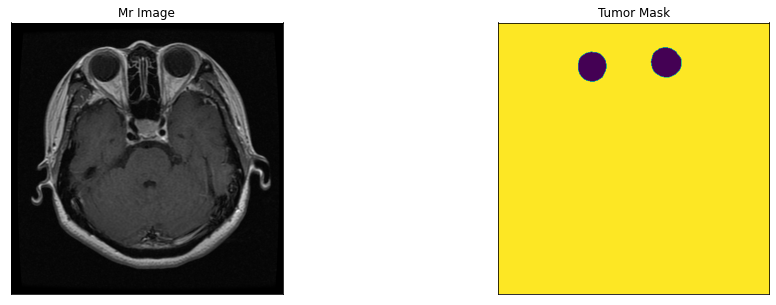

In [ ]:
def get_random_image_number():
  return random.randint(0, len(images_path_list))

dataset = Dataset(images_path_list, masks_path_list, classes=['eye'])

image, mask = dataset[get_random_image_number()] # get some sample
visualize(
    MR_image=image, 
    tumor_mask=mask
)

In [ ]:
# TODO - setup
# https://segmentation-modelspytorch.readthedocs.io/en/latest/docs/api.html#unet
# READ! https://arxiv.org/pdf/1505.04597.pdf

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
def to_tensor(x, **kwargs):
  return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
  """Construct preprocessing transform
    
  Args:
    preprocessing_fn (callbale): data normalization function 
      (can be specific for each pretrained neural network)
    Return:
      transform: albumentations.Compose
    
    """
    
  _transform = [
    albumentations.Lambda(image=preprocessing_fn),
    albumentations.Lambda(image=to_tensor, mask=to_tensor),
  ]
  return albumentations.Compose(_transform)

In [ ]:
train_dataset = Dataset(
    images_path_list, 
    masks_path_list, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    images_path_list, 
    masks_path_list, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for x epochs
# TODO => find path that not exists and then train the network
path = FOLDER_PATH + '/eye__model_as_epochs'

max_score = 0
num_epoch = 11

for i in range(0, num_epoch):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    new_path = path + str(i)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), new_path)
        print('Model saved!' + new_path)
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid:   0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 97/97 [00:05<00:00, 17.70it/s, dice_loss - 0.5805, iou_score - 0.2875]
Model saved!/content/drive/MyDrive/OSU_IT/BC_MMO/eye__model_as_epochs0

Epoch: 1
valid: 100%|██████████| 97/97 [00:05<00:00, 17.24it/s, dice_loss - 0.4587, iou_score - 0.5082]
Model saved!/content/drive/MyDrive/OSU_IT/BC_MMO/eye__model_as_epochs1

Epoch: 2
valid: 100%|██████████| 97/97 [00:05<00:00, 17.70it/s, dice_loss - 0.403, iou_score - 0.6194]
Model saved!/content/drive/MyDrive/OSU_IT/BC_MMO/eye__model_as_epochs2

Epoch: 3
valid: 100%|██████████| 97/97 [00:05<00:00, 17.75it/s, dice_loss - 0.3701, iou_score - 0.6902]
Model saved!/content/drive/MyDrive/OSU_IT/BC_MMO/eye__model_as_epochs3

Epoch: 4
valid: 100%|██████████| 97/97 [00:05<00:00, 17.64it/s, dice_loss - 0.3365, iou_score - 0.7875]
Model saved!/content/drive/MyDrive/OSU_IT/BC_MMO/eye__model_as_epochs4

Epoch: 5
valid: 100%|██████████| 97/97 [00:05<00:00, 17.56it/s, dice_loss - 0.3133, iou_score - 0.8521]
Model saved!/content/drive

In [ ]:
my_model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION
)

# path = FOLDER_PATH + '/my_segmentation_model'
## trained models description = https://docs.google.com/document/d/1iaUwroalgQNfoAuSBf23SXuD-JBw4om4YS56JbumQts/edit
# FPN model
# path = FOLDER_PATH + '/my_segmentation_model_first'
# Unet model
path = FOLDER_PATH + '/eye__model_as_epochs8'

my_model.load_state_dict(torch.load(path))
my_model.eval()

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# create test dataset

test_dataset = Dataset(
    images_path_list[10:20], 
    masks_path_list[10:20], 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# FAIL - 'collections.OrderedDict' object has no attribute 'to'
# https://stackoverflow.com/questions/49941426/attributeerror-collections-ordereddict-object-has-no-attribute-eval

# FAIL - '_IncompatibleKeys' object has no attribute 'to'
# https://discuss.pytorch.org/t/attributeerror-incompatiblekeys-object-has-no-attribute-eval/84340

# FAIL - Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 512, 512, 3] to have 3 channels, but got 512 channels instead
# https://stackoverflow.com/questions/62416819/runtimeerror-given-groups-1-weight-of-size-32-3-16-16-16-expected-input
# my problem, i delete the 'to_tensor()' function from code


In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=my_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s, dice_loss - 0.2678, iou_score - 0.9285]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    images_path_list[10:20], 
    masks_path_list[10:20], 
    classes=CLASSES,
)

In [ ]:
# FAIL - Invalid shape (2, 512, 512) for image data ???

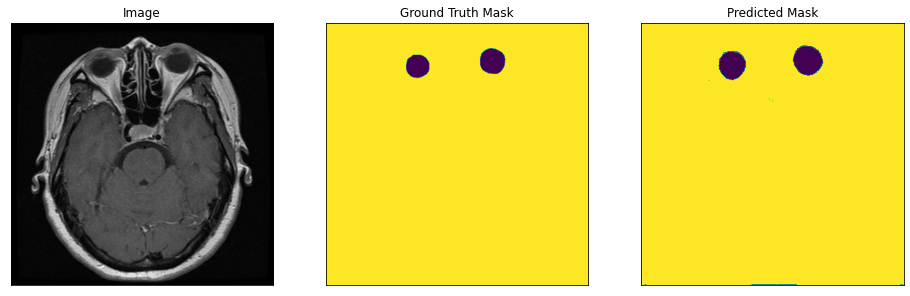

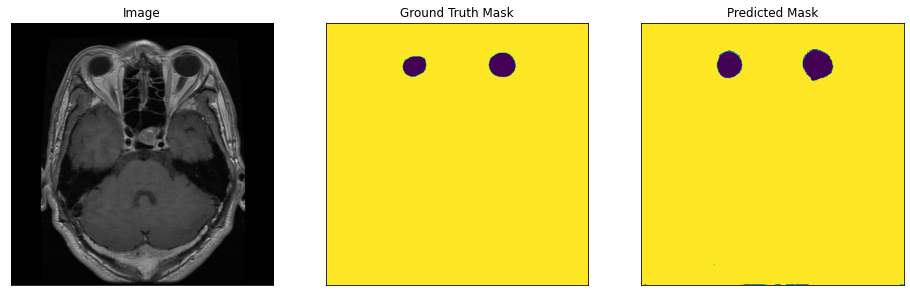

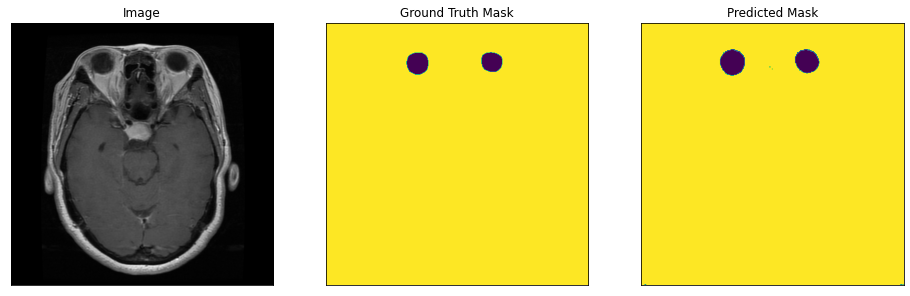

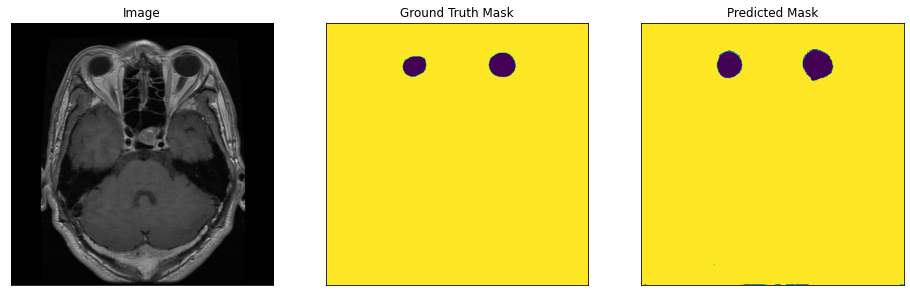

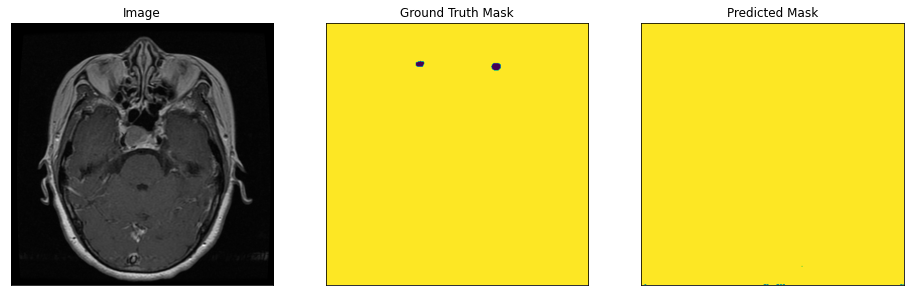

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask = np.moveaxis(gt_mask, 0, -1)
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = my_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = np.moveaxis(pr_mask, 0, -1)
  
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

    # epoch10 - oko nevyhodnotí jako nádor, ale epoch11 už ano